Loading and processing matrices...
Creating comparison plots...


FileNotFoundError: [Errno 2] No such file or directory: '/Users/jiaruizhou/Reeflink/111424/../FIGURES/Matrices/AV/AV_enso_comparison.pdf'

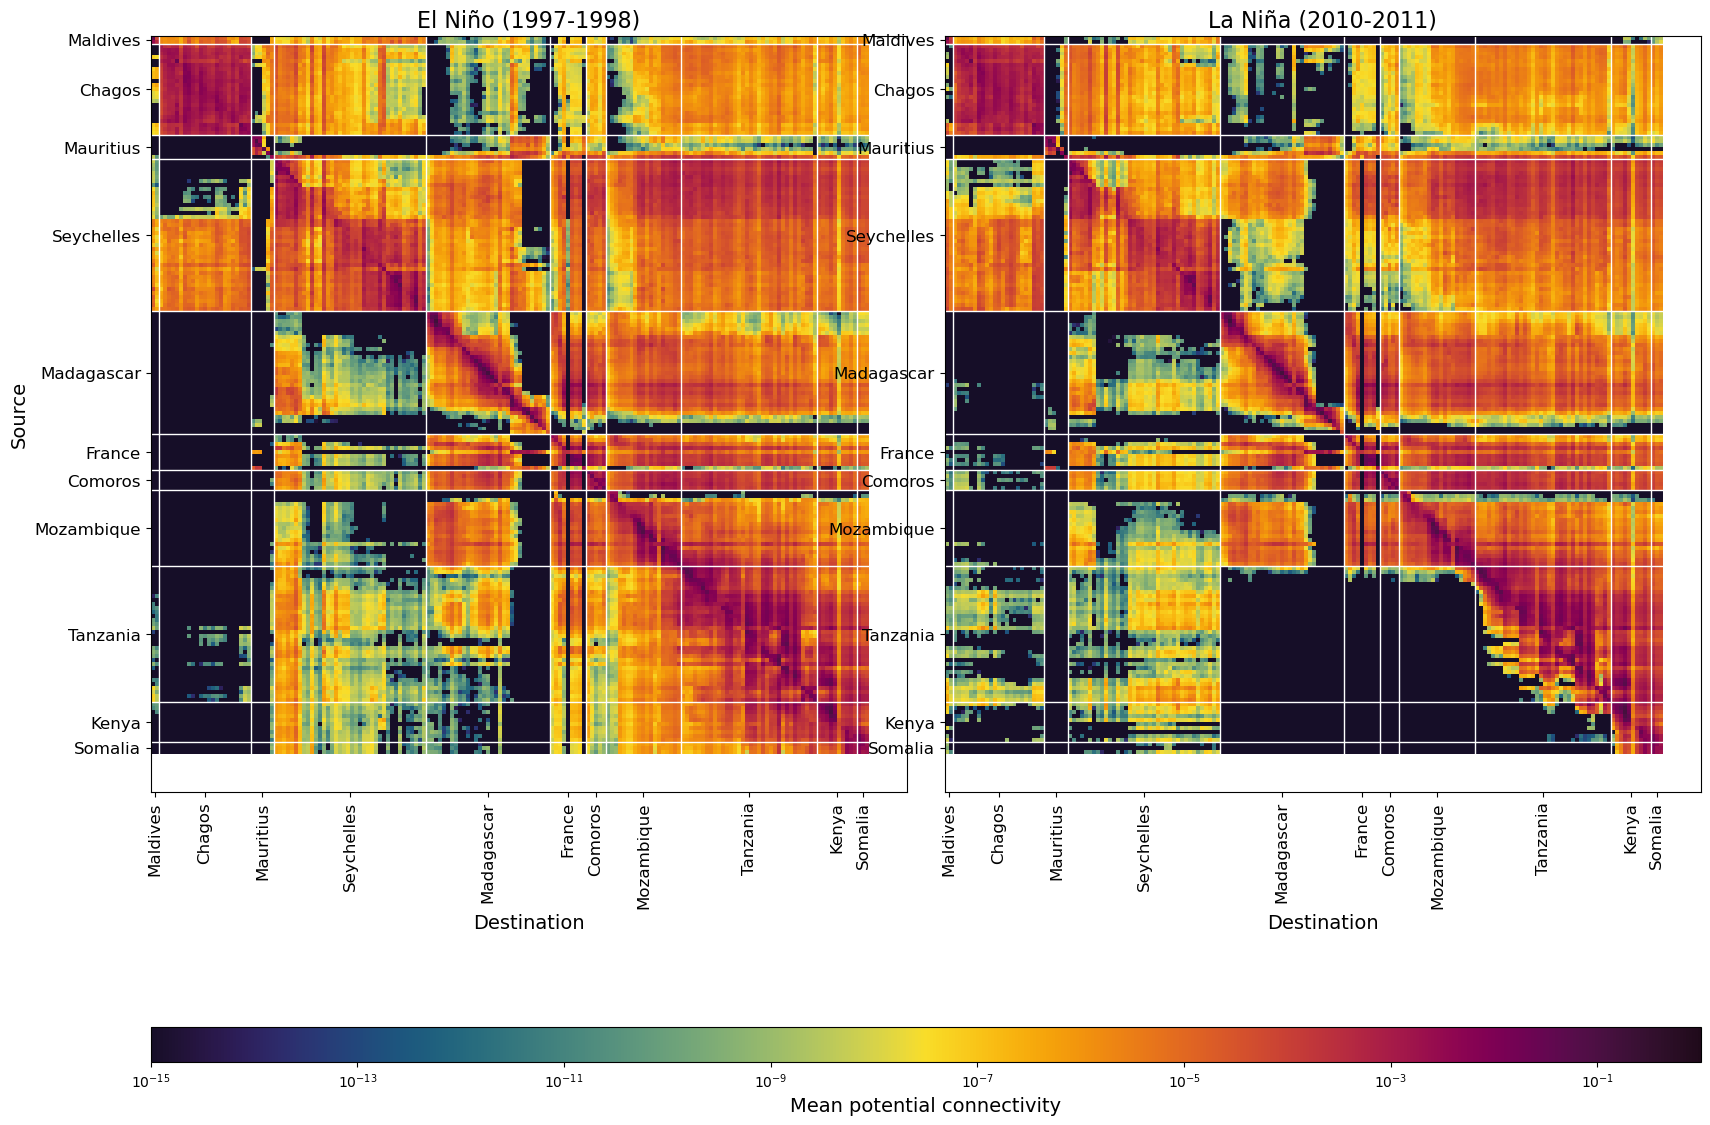

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Plot pairwise CMIC and connectivity for El Niño vs La Niña years
@author: Modified from Noam Vogt-Vincent's script
"""

import sys
sys.path.insert(0, '../VogtVincent/SIM/')
from datetime import datetime, timedelta
from connectivity import compute_CMIC
from tqdm import tqdm
from SECoW import Matrix
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import cmasher as cmr

###############################################################################
# PARAMETERS ##################################################################
###############################################################################

# Bio code
bio_code = 'AV'  # Your specific code

# Number of generations
n_gen_max = 10   # Number of generations to simulate

# Retention modifier
retention_mod = 1.0

# Define ENSO years
elnino_years = [1997, 1998]  # Strong El Niño
lanina_years = [2010, 2011]  # Strong La Niña
neutral_years = [2013]       # Neutral year

# Permitted days (JFM/OND as in original)
day_list = np.concatenate((np.arange(1, 91), np.arange(274, 366)))

# DIRECTORIES
dirs = {}
dirs['root'] = os.getcwd() + '/../'
dirs['matrix'] = dirs['root'] + 'MATRICES/' + str(bio_code) + '/'
dirs['grid'] = dirs['root'] + 'GRID_DATA/'
dirs['fig'] = dirs['root'] + 'FIGURES/Matrices/' + str(bio_code) + '/'

# FILE-HANDLES
fh = {}
fh['matrix'] = dirs['matrix'] + 'WINDS_flux_src_grp_' + bio_code + '.nc'
fh['site_list'] = dirs['grid'] + 'site_reference_grp_reordered.xlsx'

###############################################################################
# LOAD AND PROCESS DATA ######################################################
###############################################################################

print('Loading and processing matrices...')

# Load SECoW matrix
with xr.open_dataset(fh['matrix']) as file:
    matrix = Matrix(file, bio_code)
    matrix.label(fh['site_list'])

    # Get time masks for different ENSO periods
    elnino_mask = matrix.matrix.time.dt.year.isin(elnino_years)
    lanina_mask = matrix.matrix.time.dt.year.isin(lanina_years)
    neutral_mask = matrix.matrix.time.dt.year.isin(neutral_years)

    # Calculate means for different periods
    mean_matrix_elnino = (matrix.matrix.ns.sel(time=elnino_mask)/
                         matrix.matrix.rc.sel(time=elnino_mask)).mean(dim='time')
    mean_matrix_lanina = (matrix.matrix.ns.sel(time=lanina_mask)/
                         matrix.matrix.rc.sel(time=lanina_mask)).mean(dim='time')
    mean_matrix_neutral = (matrix.matrix.ns.sel(time=neutral_mask)/
                          matrix.matrix.rc.sel(time=neutral_mask)).mean(dim='time')

    # Calculate difference between El Niño and La Niña
    diff_matrix = mean_matrix_elnino - mean_matrix_lanina

    # Setup for plotting
    grp_list = list(matrix.country_dict.keys())
    axis_bnd = np.arange(len(matrix.matrix.source_group.values)+1) + 0.5

    # Get country borders for plotting
    country_border_pos = []
    for country in matrix.country_list[1:]:
        country_border_pos.append(matrix.country_bnds[country]['i0'])
    country_border_pos.append(181)

    # Get country labels
    country_tick_pos = []
    country_tick_label = []
    for country in matrix.country_list:
        if matrix.country_bnds[country]['nsites'] > 1:
            country_tick_pos.append(matrix.country_bnds[country]['mp'])
            country_tick_label.append(country)

###############################################################################
# PLOT DATA ##################################################################
###############################################################################

print('Creating comparison plots...')

# Create figure with three subplots (El Niño, La Niña, and difference)
f = plt.figure(figsize=(20, 16))
gs = GridSpec(2, 2, figure=f, height_ratios=[1, 0.03], hspace=0.05, wspace=0.05)

# Create subplots
ax1 = f.add_subplot(gs[0, 0])  # El Niño
ax2 = f.add_subplot(gs[0, 1])  # La Niña
ax3 = f.add_subplot(gs[1, :])  # Colorbar

# Plot El Niño
elnino_plot = ax1.pcolormesh(axis_bnd, axis_bnd, mean_matrix_elnino,
                            norm=colors.LogNorm(vmin=1e-15, vmax=1e0, clip=True),
                            cmap=cmr.pride)

# Plot La Niña
lanina_plot = ax2.pcolormesh(axis_bnd, axis_bnd, mean_matrix_lanina,
                            norm=colors.LogNorm(vmin=1e-15, vmax=1e0, clip=True),
                            cmap=cmr.pride)

# Add country borders to both plots
for ax in [ax1, ax2]:
    for bndry in country_border_pos:
        ax.plot([axis_bnd.min(), axis_bnd.max()],
                [bndry, bndry], 'w-', linewidth=1)
        ax.plot([bndry, bndry], [axis_bnd.min(),
                axis_bnd.max()], 'w-', linewidth=1)
    
    ax.set_aspect(1)
    ax.set_facecolor('w')
    ax.set_xticks(country_tick_pos)
    ax.set_xticklabels(country_tick_label, rotation='vertical', fontsize=12)
    ax.set_yticks(country_tick_pos)
    ax.set_yticklabels(country_tick_label, fontsize=12)
    ax.invert_yaxis()

# Add titles and labels
ax1.set_title('El Niño (1997-1998)', fontsize=16)
ax2.set_title('La Niña (2010-2011)', fontsize=16)
ax1.set_ylabel('Source', fontsize=14)
ax1.set_xlabel('Destination', fontsize=14)
ax2.set_xlabel('Destination', fontsize=14)

# Add colorbar
cbar = plt.colorbar(elnino_plot, cax=ax3, orientation='horizontal')
cbar.set_label('Mean potential connectivity', size=14)

plt.savefig(dirs['fig'] + bio_code + '_enso_comparison.pdf',
            bbox_inches='tight', dpi=300)
plt.close()

# Create difference plot
f = plt.figure(figsize=(10, 10))
ax = plt.gca()

# Plot difference (use diverging colormap)
diff_plot = ax.pcolormesh(axis_bnd, axis_bnd, diff_matrix,
                         cmap='RdBu_r', norm=colors.SymLogNorm(linthresh=1e-15))

# Add country borders
for bndry in country_border_pos:
    ax.plot([axis_bnd.min(), axis_bnd.max()],
            [bndry, bndry], 'k-', linewidth=1)
    ax.plot([bndry, bndry], [axis_bnd.min(),
            axis_bnd.max()], 'k-', linewidth=1)

ax.set_aspect(1)
ax.set_xticks(country_tick_pos)
ax.set_xticklabels(country_tick_label, rotation='vertical', fontsize=12)
ax.set_yticks(country_tick_pos)
ax.set_yticklabels(country_tick_label, fontsize=12)
ax.invert_yaxis()
ax.set_title('Connectivity Difference\n(El Niño - La Niña)', fontsize=16)
ax.set_ylabel('Source', fontsize=14)
ax.set_xlabel('Destination', fontsize=14)

plt.colorbar(diff_plot, label='Connectivity difference')
plt.savefig(dirs['fig'] + bio_code + '_enso_difference.pdf',
            bbox_inches='tight', dpi=300)
plt.close()

print('Plots saved successfully!')

# Save processed matrices to netCDF
output = xr.Dataset({
    'elnino_connectivity': mean_matrix_elnino,
    'lanina_connectivity': mean_matrix_lanina,
    'neutral_connectivity': mean_matrix_neutral,
    'connectivity_difference': diff_matrix
})

output.to_netcdf(dirs['matrix'] + bio_code + '_enso_connectivity_matrices.nc',
                 encoding={var: {'zlib': True, 'complevel': 5} 
                          for var in output.variables})